In [1]:
%matplotlib inline

import torch
import copy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from bogus import atk

sns.set()

from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor()
                   ])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [3]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 28*28)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

In [4]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def logits_forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
def train(model, lr=0.01, epochs=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train(True)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for data, target in train_loader:
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
    return model

In [6]:
def adv_test(model, test_loader, adv_func=None, adversarial=False, eps=0.2):

    model.train(False)
    correct = 0

    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data= adv_func(model, data, target, eps=eps, single=True)
        output = model(data)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred).cuda()).sum().item()
    
    
    return (correct)


In [17]:
def test(model, test_loader):

    model.train(False)
    correct = 0


    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    return correct

In [7]:
atk_func = atk().fgsm

In [23]:
results = []

In [24]:
lowest = 10000
highest = 0

for i in range(50):
    net = NNet().cuda()
    train(net)
    performance = adv_test(net, test_loader, adv_func=atk_func, adversarial=True, eps=0.2)
    results.append(performance)
    
    if performance < lowest:
        low_model = copy.deepcopy(net)
        lowest = performance
    elif performance > highest:
        high_model = copy.deepcopy(net)
        highest = performance
    
    if i % 5 == 0:
        print(i)

0
5
10
15
20
25
30
35
40
45


In [25]:
test(low_model, test_loader)

9780

In [26]:
adv_test(low_model, test_loader, adv_func=atk_func, adversarial=True, eps=0.2)

1663

In [27]:
test(high_model, test_loader)

9786

In [28]:
adv_test(high_model, test_loader, adv_func=atk_func, adversarial=True, eps=0.2)

4671

In [ ]:
def pretty_ax(ax, title_size=30, tick_size=20):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(title_size)
        item.set_color('White')
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(tick_size)
        item.set_color('White')

In [ ]:
pct_results = [i/100 for i in results]

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.hist(pct_results, bins=11)#range=(90, 100))
ax.set_title("Classification acccuracy of DNN's on adversarial test set")
ax.set_ylabel('Count')
ax.set_xlabel('Accuracy (%)')

pretty_ax(ax);

In [ ]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
mean_confidence_interval(results, confidence=0.95)

In [284]:
def filter_plotter(data, N=5):

    my_cmap = matplotlib.cm.get_cmap('bwr')

    fig = plt.figure(figsize=(20,10))

    no_filters = data.shape[0]

    for i in range(no_filters):

        filt = data[i].cpu().detach().numpy().reshape(5,5)
        filt[filt < 0] = 0 #Relu
        
        ax = fig.add_subplot(2, 5, i+1)
        # set the 'bad' values (nan) to be white and transparent
        my_cmap.set_bad(color='w', alpha=0)

        for x in range(N + 1):
            ax.axhline(x, lw=2, color='k', zorder=5)
            ax.axvline(x, lw=2, color='k', zorder=5)
        ax.imshow(filt, interpolation='none', cmap=my_cmap, extent=[0, N, 0, N], zorder=0)

        counter = 0
        for x in range(5):
            for y in range(5):
                ax.text(x+0.3, (y+.45), '{:.2f}'.format(filt.T[x][::-1][y]), fontweight='bold')
        ax.axis('off')
        
    plt.tight_layout()

In [316]:
def apply_filt(filt, img):
    result = np.zeros((24,24))
    for x in range(28):
        if x + 5 > 28: break
        for y in range(28):
            if y + 5 > 28: break

            result[x, y] = (np.sum(np.dot(img[x: x+5, y: y+5], filt)))
            
    return result

In [385]:
def apply_pooling(img):
    size = img.shape[0]
    half_size = int(size/2)
    result = np.zeros((half_size, half_size))
    xs = [i for i in range(size)][::2][:-1]
    xcount=-1
    
    for x in xs:
        xcount+=1
        ycount=-1
        for y in xs:
            ycount+=1
            result[xcount, ycount] = np.max(img[x:x+2, y:y+2])
    
    return result

In [387]:
def applied_filter_plotter(filters, img, pooling=False):


    fig = plt.figure(figsize=(20,10))

    no_filters = filters.shape[0]

    for i in range(no_filters):

        filt = filters[i].cpu().detach().numpy().reshape(5,5)
        filt[filt < 0] = 0 #Relu
        
        ax = fig.add_subplot(2, 5, i+1)
        
        result = apply_filt(filt, img)
        if pooling:
            result = apply_pooling(result)
        ax.imshow(result)
        
    plt.tight_layout()

In [56]:
data = list(low_model.parameters())[0][0].cpu().detach().numpy().reshape(5,5)

In [281]:
low_data = list(low_model.parameters())[0]

In [282]:
high_data = list(high_model.parameters())[0]

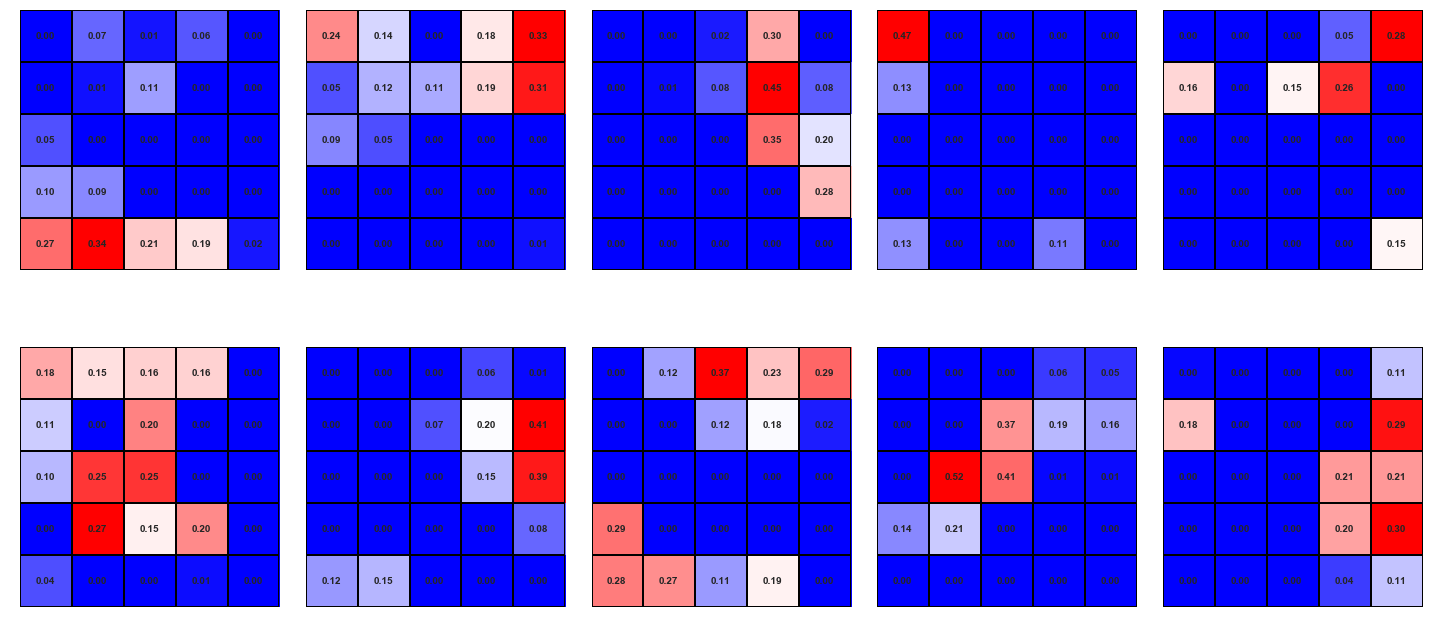

In [285]:
filter_plotter(low_data)

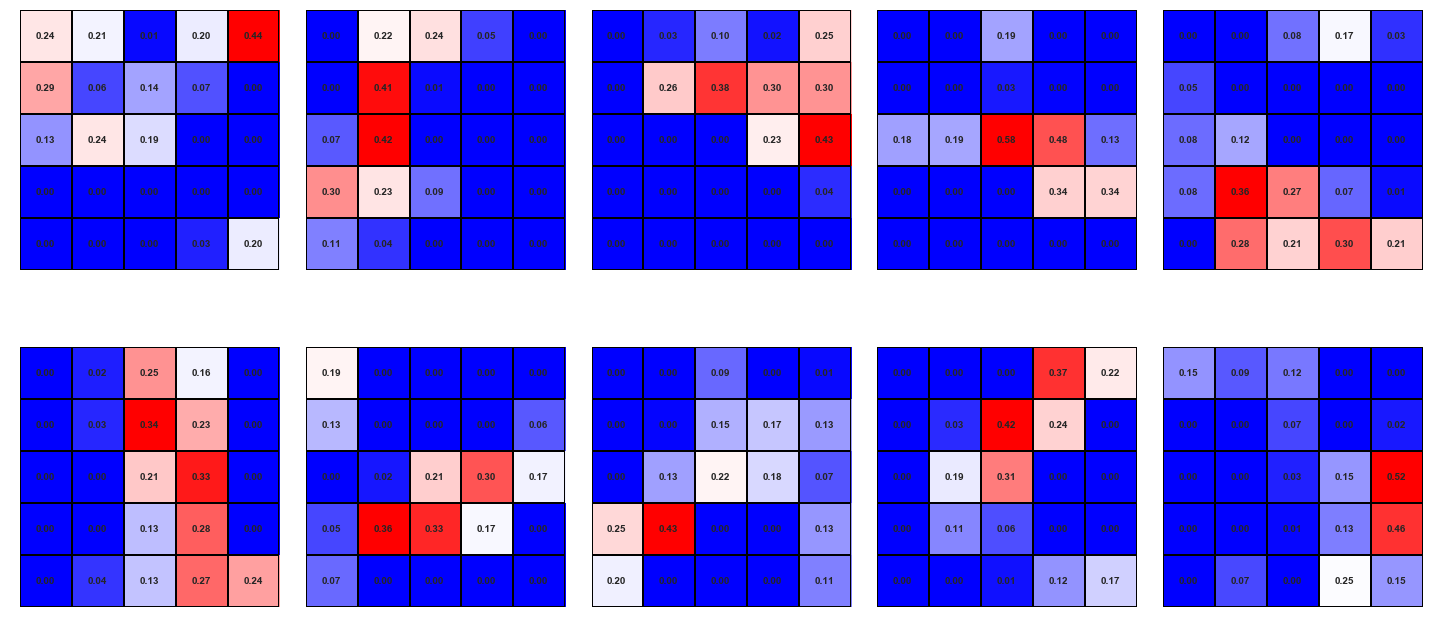

In [286]:
filter_plotter(high_data)

In [324]:
batch = next(iter(test_loader))
img = batch[0][0].cpu().detach().numpy().reshape(28,28)

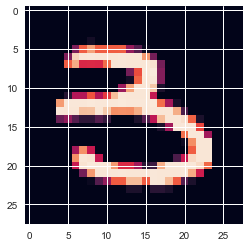

In [325]:
plt.imshow(img)

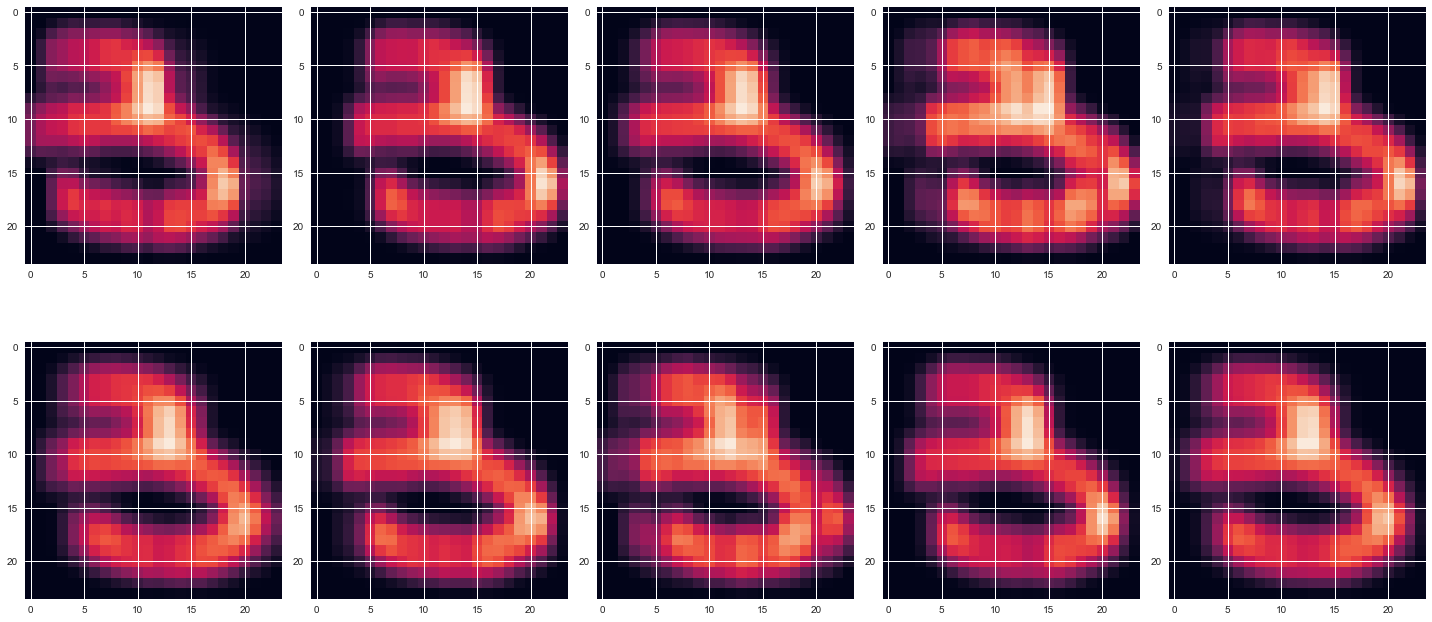

In [388]:
applied_filter_plotter(low_data, img)

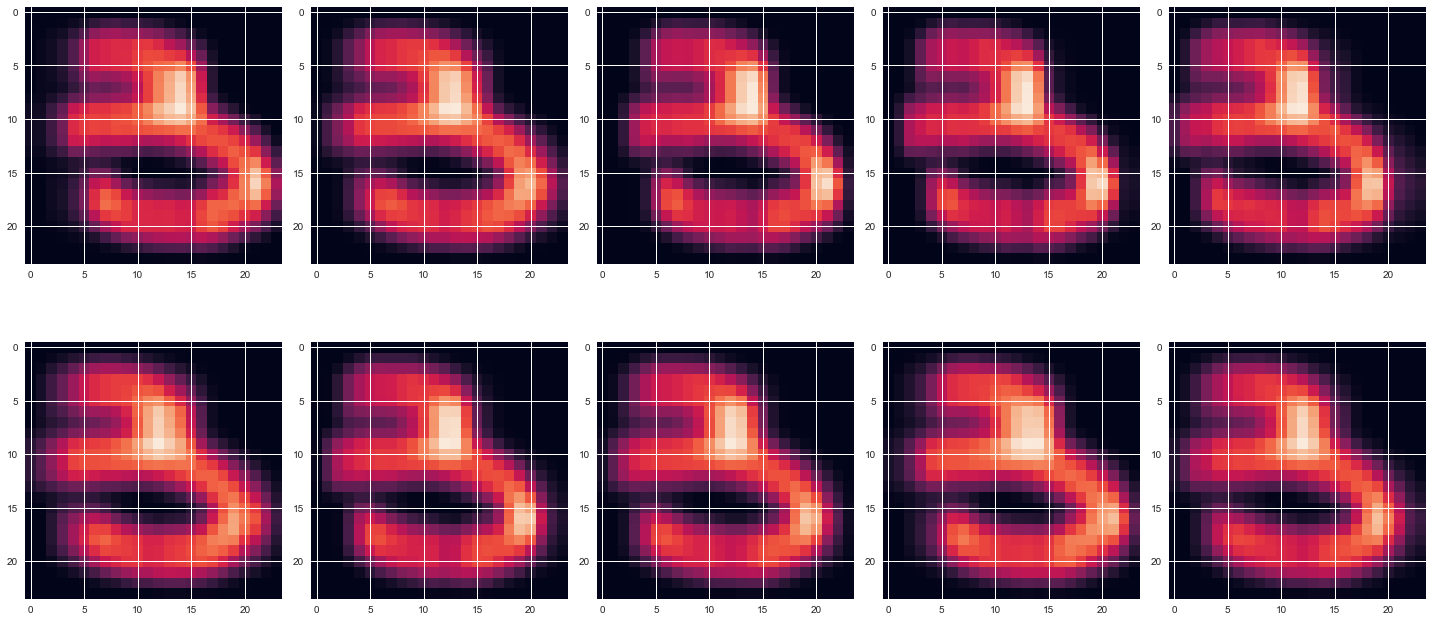

In [389]:
applied_filter_plotter(high_data, img)

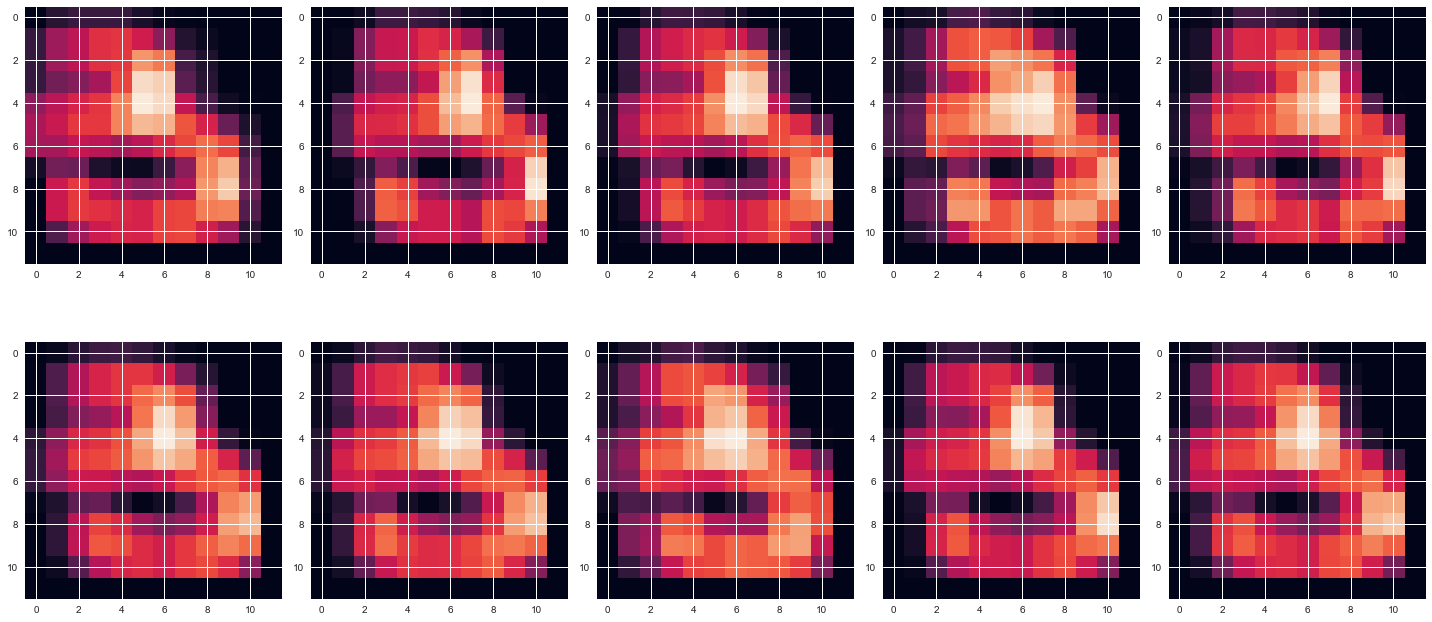

In [390]:
applied_filter_plotter(low_data, img, pooling=True)

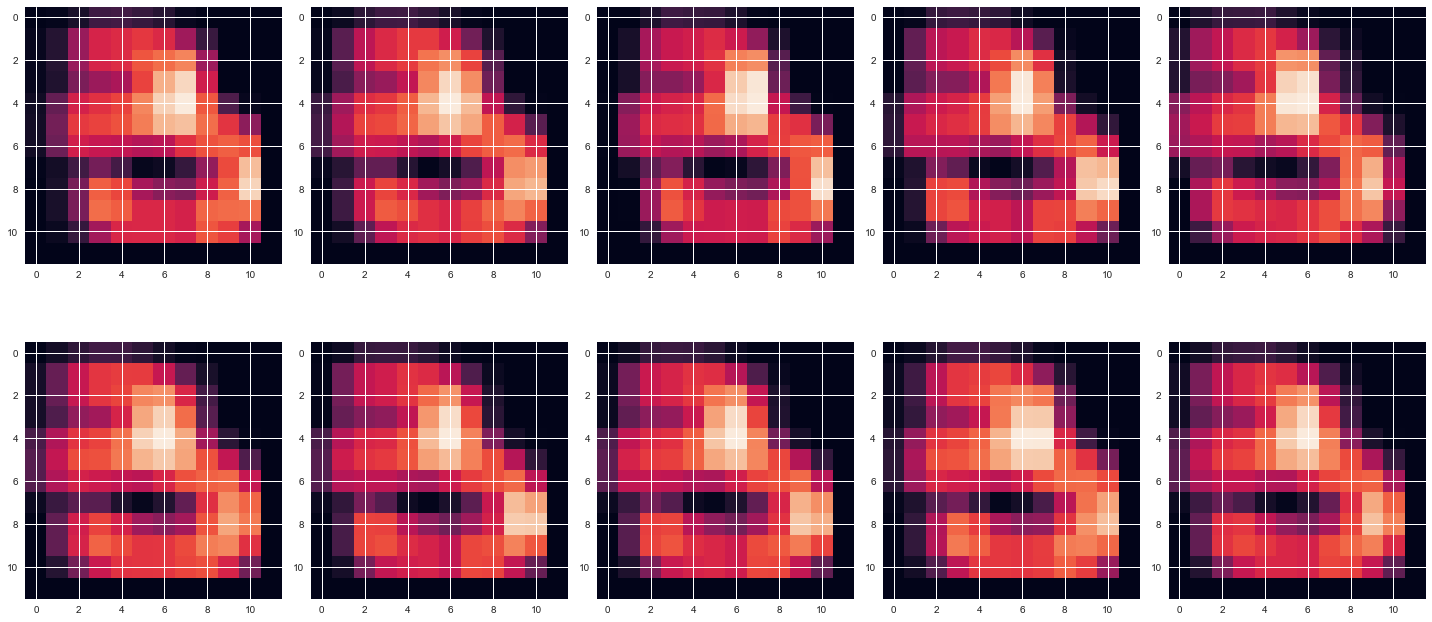

In [391]:
applied_filter_plotter(high_data, img, pooling=True)